## Funciones de limpieza

In [13]:
def clean_movie_data(df):
    """
    Limpia los datos del dataset de películas, especialmente para columnas de budget y revenue
    """
    df_clean = df.copy()

    print("🧹 Iniciando limpieza de datos...")
    print(f"Dataset original: {len(df_clean)} filas")

    # 1. Limpiar columnas de budget y revenue originales
    print("\n📊 Limpiando budget y revenue originales...")

    # Convertir a numeric, forzando errores a NaN
    df_clean['budget'] = pd.to_numeric(df_clean['budget'], errors='coerce')
    df_clean['revenue'] = pd.to_numeric(df_clean['revenue'], errors='coerce')

    # Reemplazar valores negativos y ceros con NaN (datos poco confiables)
    df_clean.loc[df_clean['budget'] <= 0, 'budget'] = np.nan
    df_clean.loc[df_clean['revenue'] <= 0, 'revenue'] = np.nan

    print(f"Budget - Valores válidos: {df_clean['budget'].count()}")
    print(f"Revenue - Valores válidos: {df_clean['revenue'].count()}")

    # 2. Limpiar inflation_factor
    print("\n💰 Limpiando factores de inflación...")

    # Asegurar que inflation_factor es numérico y positivo
    df_clean['inflation_factor'] = pd.to_numeric(df_clean['inflation_factor'], errors='coerce')
    df_clean.loc[df_clean['inflation_factor'] <= 0, 'inflation_factor'] = np.nan
    df_clean.loc[df_clean['inflation_factor'] > 100, 'inflation_factor'] = np.nan  # Valores extremos

    print(f"Inflation factor - Valores válidos: {df_clean['inflation_factor'].count()}")

    # 3. Recalcular valores reales de 2023 de forma segura
    print("\n🔄 Recalculando valores ajustados por inflación...")

    # Solo calcular para filas que tienen todos los valores necesarios
    valid_mask = (
        df_clean['budget'].notna() &
        df_clean['inflation_factor'].notna() &
        np.isfinite(df_clean['budget']) &
        np.isfinite(df_clean['inflation_factor'])
    )

    # Inicializar columnas con NaN
    df_clean['budget_real_2023'] = np.nan
    df_clean['revenue_real_2023'] = np.nan

    # Calcular budget_real_2023 solo para filas válidas
    df_clean.loc[valid_mask, 'budget_real_2023'] = (
        df_clean.loc[valid_mask, 'budget'] * df_clean.loc[valid_mask, 'inflation_factor']
    )

    # Para revenue
    valid_mask_revenue = (
        df_clean['revenue'].notna() &
        df_clean['inflation_factor'].notna() &
        np.isfinite(df_clean['revenue']) &
        np.isfinite(df_clean['inflation_factor'])
    )

    df_clean.loc[valid_mask_revenue, 'revenue_real_2023'] = (
        df_clean.loc[valid_mask_revenue, 'revenue'] * df_clean.loc[valid_mask_revenue, 'inflation_factor']
    )

    # 4. Eliminar valores extremos (outliers) que pueden causar problemas en plots
    print("\n🎯 Eliminando outliers extremos...")

    for col in ['budget_real_2023', 'revenue_real_2023']:
        if col in df_clean.columns:
            # Eliminar valores extremadamente altos (por encima del percentil 99.5)
            valid_data = df_clean[col].dropna()
            if len(valid_data) > 0:
                p99_5 = np.percentile(valid_data, 99.5)
                outlier_mask = df_clean[col] > p99_5
                df_clean.loc[outlier_mask, col] = np.nan
                print(f"{col} - Outliers eliminados: {outlier_mask.sum()}")

    # 5. Verificar y reportar calidad final de los datos
    print("\n✅ Resumen de calidad de datos:")
    cols_to_check = ['budget', 'revenue', 'budget_real_2023', 'revenue_real_2023']

    for col in cols_to_check:
        if col in df_clean.columns:
            valid_count = df_clean[col].count()
            total_count = len(df_clean)
            percentage = (valid_count / total_count) * 100

            if valid_count > 0:
                min_val = df_clean[col].min()
                max_val = df_clean[col].max()
                median_val = df_clean[col].median()
                print(f"{col}: {valid_count}/{total_count} ({percentage:.1f}%) - "
                      f"Min: ${min_val:,.0f}, Max: ${max_val:,.0f}, Median: ${median_val:,.0f}")
            else:
                print(f"{col}: {valid_count}/{total_count} ({percentage:.1f}%) - No valid data")

    print(f"\n🎬 Dataset final: {len(df_clean)} filas")

    return df_clean

# Generando embeddings para las peliculas
Los embeddings son representaciones vectoriales de las películas que capturan sus características y relaciones semánticas. Estos embeddings se pueden utilizar para tareas como la recomendación de películas, la búsqueda semántica y el análisis de similitud entre películas.


In [2]:
from utils import open_ai
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## ¿Qué son los Embeddings?

Los **embeddings** son representaciones vectoriales de alta dimensión que capturan el significado semántico y las relaciones entre diferentes elementos (en nuestro caso, películas). Estas representaciones permiten que conceptos similares estén ubicados cerca en el espacio vectorial.

### Características clave de los embeddings:
- **Densidad**: Cada dimensión del vector contiene información significativa
- **Similitud semántica**: Películas similares tienen embeddings similares  
- **Reducción dimensional**: Convierten texto complejo en vectores numéricos
- **Operabilidad matemática**: Permiten cálculos de distancia y similitud

### ¿Cómo genera OpenAI los embeddings?

OpenAI utiliza modelos de transformers pre-entrenados que:
1. **Tokenización**: Dividen el texto en tokens (palabras/subpalabras)
2. **Codificación contextual**: Cada token se representa considerando su contexto
3. **Agregación**: Los tokens se combinan en un vector único por texto
4. **Normalización**: El vector final se normaliza para comparaciones consistentes

### Modelos disponibles:
- **text-embedding-3-small**: 1536 dimensiones, 0.02/1M tokens
- **text-embedding-3-large**: 3072 dimensiones, 0.13/1M tokens
- **text-embedding-ada-002**: 1536 dimensiones, 0.01/1M tokens (legacy)


In [9]:
# Cargamos los datos de películas con pkl
movies_grouped = pd.read_csv('../../data/origin_data/TMDB_all_movies.csv')

# movies_grouped = movies.groupby('id').agg(
#     adult=('adult', 'first'),
#     budget=('budget', 'first'),
#     original_language=('original_language', 'first'),
#     original_title=('original_title', 'first'),
#     title=('title', 'first'),
#     genres=('genres', 'first'),
#     overview=('overview', 'first'),
#     all_actors_names_text=('all_actors_names_text', 'first'),
#     keywords_text=('keywords_text', 'first'),
#     vote_average=('vote_average', 'first'),
#     vote_count=('vote_count', 'first'),
#     rating_mean=('rating', 'mean'),
#     rating_count=('rating', 'count'),
#     timestamp=('timestamp', 'max'),
#     popularity=('popularity', 'first'),
#     production_companies=('production_companies', 'first'),
#     release_date=('release_date', 'first'),
#     revenue=('revenue', 'first'),
#     runtime=('runtime', 'first'),
#     spoken_languages=('spoken_languages', 'first'),
#     tagline=('tagline', 'first'),
#     video=('video', 'first'),
#     collection=('collection', 'first'),
#     movieId=('movieId', 'first')
# ).reset_index()


In [10]:
print(f"Dataset shape: {movies_grouped.shape}")
print(f"Columnas: {list(movies_grouped.columns)}")


Dataset shape: (1097346, 28)
Columnas: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'budget', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'director', 'director_of_photography', 'writers', 'producers', 'music_composer', 'imdb_rating', 'imdb_votes', 'poster_path']


### Primera limpieza de los datos
Solo cogemos aquellas películas con budget y reveneu != 0

In [14]:
# Filtro combinado para el dataset de películas
# Aplicando las condiciones: budget != 0, revenue != 0, y géneros no nulos

# Opción 1: Filtros paso a paso (más legible)
movies_filtered = movies_grouped[movies_grouped['budget'] > 0]
movies_filtered = movies_filtered[movies_filtered['revenue'] > 0]
movies_filtered = movies_filtered[movies_filtered['genres'].notnull()]

# Opción 2: Filtro combinado en una sola línea
movies_filtered = movies_grouped[
    (movies_grouped['budget'] > 0) &
    (movies_grouped['revenue'] > 0) &
    (movies_grouped['genres'].notnull())
]

# Opción 3: Usando query() para mayor claridad
movies_filtered = movies_grouped.query('budget > 0 and revenue > 0').dropna(subset=['genres'])

# Verificar el resultado
print(f"Dataset original: {len(movies_grouped)} películas")
print(f"Dataset filtrado: {len(movies_filtered)} películas")
print(f"Porcentaje retenido: {len(movies_filtered)/len(movies_grouped)*100:.1f}%")

Dataset original: 1097346 películas
Dataset filtrado: 15365 películas
Porcentaje retenido: 1.4%


## Creamos el objeto cliente de OpenAI para generar los embeddings


In [31]:
client = open_ai.OpenAIRepository()
embedding_model = open_ai.EmbeddingModel.TEXT_EMBEDDING_3_LARGE


📁 Cargando desde .env
✅ Clave cargada desde variables de entorno: sk-proj-cPotJ3v...
🔑 Clave API configurada: sk-proj-cPotJ3v...
📏 Longitud: 164 caracteres
🔄 Probando conexión con OpenAI...
✅ Conexión con OpenAI verificada exitosamente


## Costo de los embeddings con openAI
El costo de los embeddings se refiere al costo asociado con la generación de representaciones vectoriales de
las películas utilizando modelos de lenguaje como OpenAI. Este costo puede variar según el modelo utilizado y la cantidad de datos procesados. El precio se da por el costo por el millón de tokens procesados, y es importante tener en cuenta este costo al planificar el uso de embeddings en aplicaciones a gran escala.


In [35]:
# Definimos las características de texto disponibles en el dataset
text_features_list = [
    'title',                 # "The Dark Knight", "Titanic"
    'original_title',        # Títulos en idioma original
    'overview',              # Sinopsis/descripción de la película
    'tagline',               # "Why so serious?", "Nothing on Earth could come between them"
    'genres',                # Géneros de la película
    'production_companies',  # Nombres de productoras
    'production_countries',  # Países de producción
    'spoken_languages',      # Idiomas hablados
    'cast',                  # Reparto (si está disponible como texto)
    'director'               # Director(es)
]

# Verificamos qué columnas están realmente disponibles
available_columns = []
missing_columns = []

for col in text_features_list:
    if col in movies_filtered.columns:
        available_columns.append(col)
    else:
        missing_columns.append(col)

print("Columnas disponibles para texto:", available_columns)
if missing_columns:
    print("Columnas faltantes:", missing_columns)

# MÉTODO CORREGIDO: Concatenamos todas las características de texto disponibles
if available_columns:
    # Empezamos con la primera columna
    text_features = movies_filtered[available_columns[0]].fillna('')

    # Agregamos las demás columnas una por una
    for col in available_columns[1:]:
        text_features = text_features + ' ' + movies_filtered[col].fillna('')
else:
    text_features = movies_filtered['overview'].fillna('')

# Método alternativo explícito (más control):
text_features_explicit = (
    movies_filtered['title'].fillna('') + ' ' +
    movies_filtered['original_title'].fillna('') + ' ' +
    movies_filtered['overview'].fillna('') + ' ' +
    movies_filtered['tagline'].fillna('') + ' ' +
    movies_filtered['genres'].fillna('') + ' ' +
    movies_filtered['production_companies'].fillna('') + ' ' +
    movies_filtered['production_countries'].fillna('') + ' ' +
    movies_filtered['spoken_languages'].fillna('') + ' ' +
    movies_filtered['cast'].fillna('') + ' ' +
    movies_filtered['director'].fillna('')
)

movies_filtered['all_text_joined'] = text_features_explicit

# Calculamos el costo usando cualquiera de las dos versiones
# Usemos la versión automática
costo_total_text_features = text_features.map(
    lambda x: client.calculate_embedding_cost(x, embedding_model)
).sum()

print(f"\nCosto total de los embeddings de texto: ${costo_total_text_features:.4f} USD")
print(f"Número de películas a procesar: {len(text_features)}")
print(f"Costo promedio por película: ${costo_total_text_features / len(text_features):.6f} USD")

# Mostramos una muestra del texto combinado
print(f"\nEjemplo de texto combinado (primera película):")
print(text_features.iloc[0][:200] + "...")

# Verificamos que no hay valores nulos problemáticos
print(f"\nLongitud promedio del texto: {text_features.str.len().mean():.0f} caracteres")
print(f"Texto más largo: {text_features.str.len().max()} caracteres")
print(f"Texto más corto: {text_features.str.len().min()} caracteres")

Columnas disponibles para texto: ['title', 'original_title', 'overview', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'director']

Costo total de los embeddings de texto: $0.4552 USD
Número de películas a procesar: 15365
Costo promedio por película: $0.000030 USD

Ejemplo de texto combinado (primera película):
Four Rooms Four Rooms It's Ted the Bellhop's first night on the job...and the hotel's very unusual guests are about to place him in some outrageous predicaments. It seems that this evening's room serv...

Longitud promedio del texto: 872 caracteres
Texto más largo: 6646 caracteres
Texto más corto: 21 caracteres


### Ejemplos de texto combinado para embeddings


In [36]:
movies_grouped['all_text_joined'] = text_features

# Mostramos algunos ejemplos
sample_texts = movies_filtered[['id', 'title', 'all_text_joined']].sample(5)
for idx, row in sample_texts.iterrows():
    print(f"\n🎬 Película: {row['title']}")
    print(f"📝 Texto para embedding: {row['all_text_joined'][:200]}...")
    print(f"📏 Longitud total: {len(row['all_text_joined'])} caracteres")



🎬 Película: Trouble in Mind
📝 Texto para embedding: Trouble in Mind Trouble in Mind The lives of an ex-con, a coffee-shop owner, and a young couple looking to make it rich intersect in the hypnotic Rain City. Drugs, sex, crime… Rain City has it all. He...
📏 Longitud total: 1509 caracteres

🎬 Película: Transformers: The Last Knight
📝 Texto para embedding: Transformers: The Last Knight Transformers: The Last Knight Humans and Transformers are at war. Optimus Prime is gone. The key to saving our future lies buried in the secrets of the past, in the hidde...
📏 Longitud total: 1907 caracteres

🎬 Película: Pink Bullet
📝 Texto para embedding: Pink Bullet Pink Bullet Two drag queens living in a place where homophobia and transphobia are common open their hearts to the world, revealing the human being behind the makeup and wigs. They share t...
📏 Longitud total: 394 caracteres

🎬 Película: Mission: Impossible II
📝 Texto para embedding: Mission: Impossible II Mission: Impossible II With compute

## Generando los embeddings

### Estrategia de procesamiento:
- Procesamos en lotes para optimizar las llamadas a la API
- Guardamos progreso intermedio para evitar pérdidas por errores
- Mostramos barra de progreso para seguimiento


In [22]:
# Ejemplo de embedding 
vector = client.get_embedding('Hello world', embedding_model)
print(f'La dimensión de los vectores generados por el modelo {embedding_model.model_name} es de {len(vector)}')
print(f'Los primeros 5 componentes son: {vector[:5]}')



La dimensión de los vectores generados por el modelo text-embedding-3-small es de 1536
Los primeros 5 componentes son: [-0.002078542485833168, -0.04908587411046028, 0.020946789532899857, 0.03135102614760399, -0.04530530795454979]


### Generación masiva de embeddings


In [28]:
import asyncio
import aiohttp
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time

def generate_embeddings_batch_optimized(texts, client, model, batch_size=100, max_workers=5):
    """
    Genera embeddings en lotes optimizado con paralelización
    """
    embeddings = []
    total_cost = 0

    # Procesar en lotes más grandes si la API lo permite
    for i in tqdm(range(0, len(texts), batch_size), desc="Generando embeddings"):
        batch = texts[i:i + batch_size]

        try:
            # Llamada en lote (si tu cliente lo soporta)
            batch_embeddings, batch_cost = client.get_embeddings_batch_with_cost(batch, model)
            embeddings.extend(batch_embeddings)
            total_cost += batch_cost

        except AttributeError:
            # Fallback: procesamiento paralelo
            batch_embeddings, batch_cost = _process_batch_parallel(batch, client, model, max_workers)
            embeddings.extend(batch_embeddings)
            total_cost += batch_cost

    return embeddings, total_cost

def _process_batch_parallel(batch, client, model, max_workers):
    """
    Procesa un lote en paralelo usando ThreadPoolExecutor
    """
    embeddings = []
    total_cost = 0

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Enviar todas las tareas al pool
        futures = [executor.submit(_get_single_embedding, text, client, model) for text in batch]

        # Recoger resultados
        for future in futures:
            try:
                embedding, cost = future.result(timeout=30)  # 30 seg timeout
                embeddings.append(embedding)
                total_cost += cost
            except Exception as e:
                print(f"Error procesando texto: {e}")
                embeddings.append([0.0] * model.dimensions)

    return embeddings, total_cost

def _get_single_embedding(text, client, model):
    """
    Función auxiliar para obtener embedding individual
    """
    return client.get_embedding_with_cost(text, model)

# Versión asíncrona (más rápida si tu cliente soporta async)
async def generate_embeddings_async(texts, client, model, batch_size=100, concurrent_requests=10):
    """
    Versión asíncrona para máximo rendimiento
    """
    embeddings = []
    total_cost = 0

    # Crear semáforo para limitar requests concurrentes
    semaphore = asyncio.Semaphore(concurrent_requests)

    async def get_embedding_with_semaphore(text):
        async with semaphore:
            try:
                embedding, cost = await client.aget_embedding_with_cost(text, model)
                return embedding, cost
            except Exception as e:
                print(f"Error procesando texto: {e}")
                return [0.0] * model.dimensions, 0

    # Procesar en lotes
    for i in tqdm(range(0, len(texts), batch_size), desc="Generando embeddings async"):
        batch = texts[i:i + batch_size]

        # Crear tareas para el lote
        tasks = [get_embedding_with_semaphore(text) for text in batch]

        # Ejecutar todas las tareas del lote
        results = await asyncio.gather(*tasks, return_exceptions=True)

        # Procesar resultados
        for result in results:
            if isinstance(result, Exception):
                embeddings.append([0.0] * model.dimensions)
            else:
                embedding, cost = result
                embeddings.append(embedding)
                total_cost += cost

    return embeddings, total_cost


In [37]:
# Versión optimizada para tu caso específico
print("🚀 Iniciando generación de embeddings optimizada...")
start_time = time.time()

# Opción 1: Versión paralela (recomendada)
embeddings, total_cost = generate_embeddings_batch_optimized(
    movies_filtered['all_text_joined'].tolist(),
    client,
    embedding_model,
    batch_size=500,  # Incrementado de 50 a 200
    max_workers=8    # Procesamiento paralelo
)


print(f"✅ Embeddings generados exitosamente!")
print(f"💰 Costo total real: ${total_cost:.4f} USD")
print(f"📊 Dimensiones por embedding: {len(embeddings[0])}")
print(f"🎬 Total de películas procesadas: {len(embeddings)}")

# Información adicional de rendimiento
import time
end_time = time.time()
if 'start_time' in locals():
    elapsed_time = end_time - start_time
    movies_per_second = len(embeddings) / elapsed_time
    print(f"⚡ Rendimiento: {movies_per_second:.1f} películas/segundo")
    print(f"⏱️  Tiempo total: {elapsed_time:.1f} segundos")




🚀 Iniciando generación de embeddings optimizada...


Generando embeddings: 100%|██████████| 31/31 [10:01<00:00, 19.41s/it]

✅ Embeddings generados exitosamente!
💰 Costo total real: $0.4552 USD
📊 Dimensiones por embedding: 3072
🎬 Total de películas procesadas: 15365
⚡ Rendimiento: 25.5 películas/segundo
⏱️  Tiempo total: 601.6 segundos


In [46]:
# Primero convierte la columna a datetime
movies_filtered['release_date'] = pd.to_datetime(movies_filtered['release_date'])

# Luego extrae el año y mes
movies_filtered['release_year'] = movies_filtered['release_date'].dt.year
movies_filtered['release_month'] = movies_filtered['release_date'].dt.month
# Guardar embeddings
movies_filtered['embedding'] = embeddings
movies_filtered.to_pickle('../../data/origin_data/movies_with_embeddings_and_filtered.csv')

### Corrección de la inflacción

In [14]:
# Factores de inflación para conversión a dólares de 2023 (1911-2024)
inflation_data_extended = {
    1911: 32.700, 1912: 31.572, 1913: 30.828, 1914: 30.419, 1915: 30.118,
    1916: 28.000, 1917: 23.782, 1918: 20.257, 1919: 17.574, 1920: 15.209,
    1921: 17.082, 1922: 18.203, 1923: 17.883, 1924: 17.779, 1925: 17.374,
    1926: 17.211, 1927: 17.540, 1928: 17.744, 1929: 17.744, 1930: 18.239,
    1931: 20.035, 1932: 22.332, 1933: 23.537, 1934: 22.776, 1935: 22.223,
    1936: 21.957, 1937: 21.194, 1938: 21.645, 1939: 21.904, 1940: 21.748,
    1941: 20.715, 1942: 18.648, 1943: 17.608, 1944: 17.308, 1945: 16.924,
    1946: 15.625, 1947: 13.645, 1948: 12.681, 1949: 12.806, 1950: 12.664,
    1951: 11.738, 1952: 11.474, 1953: 11.388, 1954: 11.346, 1955: 11.374,
    1956: 11.207, 1957: 10.848, 1958: 10.561, 1959: 10.452, 1960: 10.299,
    1961: 10.196, 1962: 10.073, 1963: 9.952, 1964: 9.824, 1965: 9.668,
    1966: 9.391, 1967: 9.138, 1968: 8.762, 1969: 8.309, 1970: 7.846,
    1971: 7.523, 1972: 7.284, 1973: 6.864, 1974: 6.178, 1975: 5.662,
    1976: 5.354, 1977: 5.028, 1978: 4.671, 1979: 4.198, 1980: 3.698,
    1981: 3.351, 1982: 3.157, 1983: 3.059, 1984: 2.933, 1985: 2.833,
    1986: 2.780, 1987: 2.682, 1988: 2.576, 1989: 2.458, 1990: 2.332,
    1991: 2.237, 1992: 2.171, 1993: 2.109, 1994: 2.056, 1995: 2.000,
    1996: 1.943, 1997: 1.898, 1998: 1.869, 1999: 1.829, 2000: 1.769,
    2001: 1.721, 2002: 1.694, 2003: 1.656, 2004: 1.613, 2005: 1.560,
    2006: 1.511, 2007: 1.469, 2008: 1.415, 2009: 1.420, 2010: 1.397,
    2011: 1.354, 2012: 1.327, 2013: 1.308, 2014: 1.287, 2015: 1.285,
    2016: 1.270, 2017: 1.243, 2018: 1.213, 2019: 1.192, 2020: 1.177,
    2021: 1.124, 2022: 1.041, 2023: 1.000, 2024: 0.971
}


def apply_inflation_adjustment_extended(df, inflation_dict, year_col='release_year',
                                       value_cols=['budget', 'revenue'], target_year=2023):
    """
    Aplica corrección por inflación a las columnas especificadas

    Parameters:
    -----------
    df : DataFrame
        Dataset con las películas
    inflation_dict : dict
        Diccionario con factores de inflación por año
    year_col : str
        Nombre de la columna que contiene el año
    value_cols : list
        Lista de columnas a ajustar por inflación
    target_year : int
        Año base para la conversión (2023 por defecto)

    Returns:
    --------
    DataFrame con columnas ajustadas agregadas
    """
    import pandas as pd

    df_adjusted = df.copy()

    # Mapear factores de inflación
    df_adjusted['inflation_factor'] = df_adjusted[year_col].map(inflation_dict)

    # Manejar años fuera del rango usando vectorización
    mask_missing = df_adjusted['inflation_factor'].isna() & df_adjusted[year_col].notna()

    # Para años anteriores a 1911
    mask_old = mask_missing & (df_adjusted[year_col] < 1911)
    df_adjusted.loc[mask_old, 'inflation_factor'] = inflation_dict[1911] * 1.1

    # Para años posteriores a 2024
    mask_future = mask_missing & (df_adjusted[year_col] > 2024)
    df_adjusted.loc[mask_future, 'inflation_factor'] = inflation_dict[2024]

    # Aplicar ajuste por inflación a cada columna
    for col in value_cols:
        if col in df_adjusted.columns:
            adjusted_col = f"{col}_real_{target_year}"
            df_adjusted[adjusted_col] = df_adjusted[col] * df_adjusted['inflation_factor']

    return df_adjusted


DATA_PATH = "../../data/processed_data/movies_with_embeddings_filtered_inflation_correction.pkl"
df = pd.read_pickle(DATA_PATH)
new_df = clean_movie_data(apply_inflation_adjustment_extended(df, inflation_dict=inflation_data_extended))
# overwrite
new_df.to_pickle(DATA_PATH)


🧹 Iniciando limpieza de datos...
Dataset original: 15365 filas

📊 Limpiando budget y revenue originales...
Budget - Valores válidos: 15365
Revenue - Valores válidos: 15365

💰 Limpiando factores de inflación...
Inflation factor - Valores válidos: 14963

🔄 Recalculando valores ajustados por inflación...

🎯 Eliminando outliers extremos...
budget_real_2023 - Outliers eliminados: 75
revenue_real_2023 - Outliers eliminados: 75

✅ Resumen de calidad de datos:
budget: 15365/15365 (100.0%) - Min: $1, Max: $583,900,000, Median: $4,800,000
revenue: 15365/15365 (100.0%) - Min: $1, Max: $2,923,706,026, Median: $4,600,000
budget_real_2023: 14888/15365 (96.9%) - Min: $1, Max: $265,400,000, Median: $9,942,000
revenue_real_2023: 14888/15365 (96.9%) - Min: $1, Max: $1,378,234,512, Median: $11,186,618

🎬 Dataset final: 15365 filas


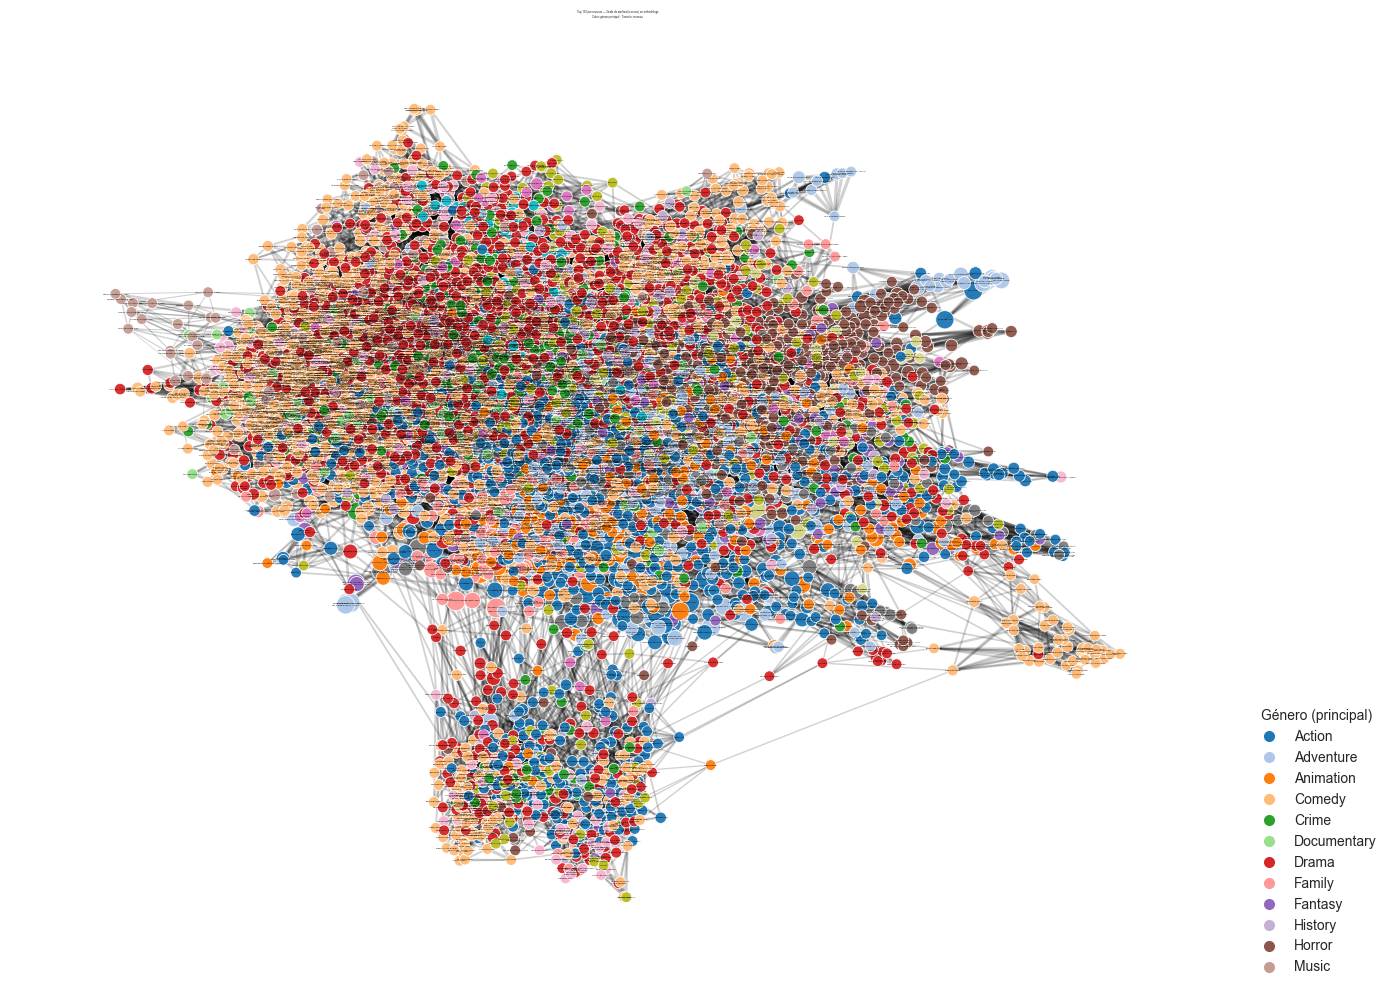

In [15]:
# === Grafo de similitud (coseno) con las 100 películas de mayor revenue ===
# Requisitos: networkx, numpy, pandas, matplotlib (y dataset con columna 'embedding')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Si no tienes networkx instalado, instálalo con:  pip install networkx
import networkx as nx

# ------------------ 1) Cargar dataset con embeddings ------------------
# Ajusta la ruta si guardaste el pkl en otro lugar
DATA_PATH = "../../data/processed_data/movies_with_embeddings_filtered_inflation_correction.pkl"
df = pd.read_pickle(DATA_PATH)

# Asegurar que existe la columna de embeddings
assert 'embedding' in df.columns, "No se encontró la columna 'embedding' en el dataset."

# ------------------ 2) Top-100 por revenue ------------------
df_top = (
    df[df['revenue_real_2023'] > 0]
    .dropna(subset=['embedding'])
    .sort_values('revenue_real_2023', ascending=False)
    .head(10000)
    .reset_index(drop=True)
)

# Embeddings como matriz (n, d) y normalización L2 (coseno = producto punto)
X = np.vstack(df_top['embedding'].values).astype(np.float32)
X = X / np.clip(np.linalg.norm(X, axis=1, keepdims=True), 1e-12, None)

# Similitudes coseno (n x n)
S = X @ X.T

# ------------------ 3) Construcción del grafo (k-NN simétrico) ------------------
k = 6  # vecinos por nodo (ajusta según densidad que quieras)
G = nx.Graph()

def main_genre(g):
    if pd.isna(g):
        return "Unknown"
    g0 = str(g).split(",")[0].strip()
    return g0 if g0 else "Unknown"

# Crear nodos con atributos
for i, row in df_top.iterrows():
    G.add_node(
        i,
        title=row.get('title', row.get('original_title', f"movie_{i}")),
        genre=main_genre(row.get('genres', "")),
        revenue=float(row['revenue'])
    )

# Añadir aristas por k vecinos más similares (simetrizado)
n = len(df_top)
for i in range(n):
    # índices ordenados por similitud descendente (excluyendo i)
    neigh = np.argsort(S[i])[::-1]
    neigh = [j for j in neigh if j != i][:k]
    for j in neigh:
        if not G.has_edge(i, j):
            G.add_edge(i, j, weight=float(S[i, j]))

# ------------------ 4) Layout y estilo ------------------
# Layout por fuerza (spring), usando 'weight' para acercar los más similares
pos = nx.spring_layout(G, weight='weight', k=0.35, iterations=300, seed=42)

# Colores por género principal (máx. 20 colores distintos)
genres = [G.nodes[n]['genre'] for n in G.nodes]
uniq_genres = sorted(set(genres))
cmap = plt.cm.get_cmap("tab20", max(20, len(uniq_genres)))
color_map = {g: cmap(i % 20) for i, g in enumerate(uniq_genres)}
node_colors = [color_map[g] for g in genres]

# Tamaño por revenue (escala suave)
revs = np.array([G.nodes[n]['revenue'] for n in G.nodes], dtype=np.float64)
sizes = 200 * (0.3 + (revs - revs.min()) / (revs.max() - revs.min() + 1e-9))  # 60..260 aprox

# Grosor de aristas por similitud
edge_w = np.array([G.edges[e]['weight'] for e in G.edges], dtype=np.float32)
edge_w = 0.5 + 2.5 * (edge_w - edge_w.min()) / (edge_w.max() - edge_w.min() + 1e-9)

# ------------------ 5) Dibujo ------------------
plt.figure(figsize=(14, 10))
nx.draw_networkx_edges(G, pos, alpha=0.18, width=edge_w)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=sizes,
                       alpha=0.95, linewidths=0.6, edgecolors='white')

# Etiquetas: "Título (Género)"
def trunc(s, maxlen=32):
    s = s if isinstance(s, str) else str(s)
    return s if len(s) <= maxlen else s[:maxlen - 1] + "…"

labels = {n: f"{trunc(G.nodes[n]['title'])} ({G.nodes[n]['genre']})" for n in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=0)

plt.title("Top 100 por revenue — Grafo de similitud (coseno) en embeddings\nColor: género principal · Tamaño: revenue", fontsize=2)
plt.axis('off')

# Leyenda compacta (primeros 12 géneros para no saturar)
from matplotlib.lines import Line2D
legend_items = [Line2D([0], [0], marker='o', color='w', label=g,
                       markerfacecolor=color_map[g], markersize=8)
                for g in uniq_genres[:12]]
if legend_items:
    plt.legend(handles=legend_items, title="Género (principal)",
               loc='lower left', bbox_to_anchor=(1.02, 0), borderaxespad=0.)

plt.tight_layout()
plt.show()


Cargando datos...
Datos cargados: 14963 películas
Shape de embeddings: (14963, 3072)
Aplicando SVD...
SVD completado con 512 componentes
Analizando R² para diferentes números de componentes...
Procesando k=50...
Procesando k=100...
Procesando k=150...
Procesando k=200...
Procesando k=250...
Procesando k=300...
Procesando k=350...
Procesando k=400...
Procesando k=450...
Procesando k=500...

Sugerencia de corte: k=200
R² en el corte: 0.749
Varianza acumulada: 69.2%
Figura guardada en: ./svd_revenue_explained.png


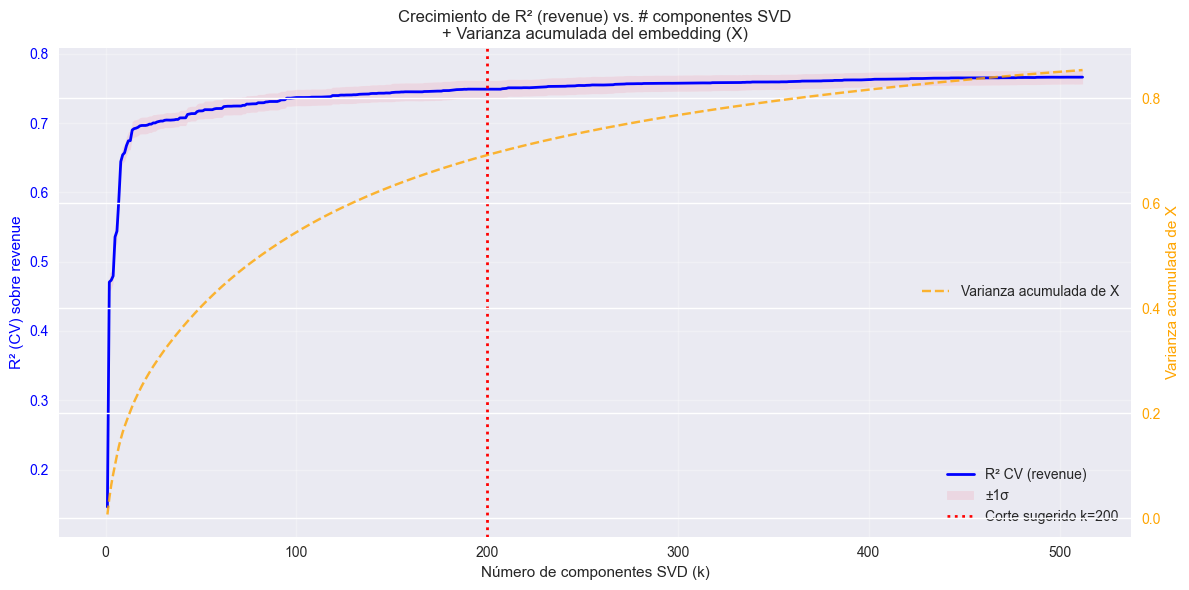

Figura (Δ) guardada en: svd_revenue_explained_marginal.png


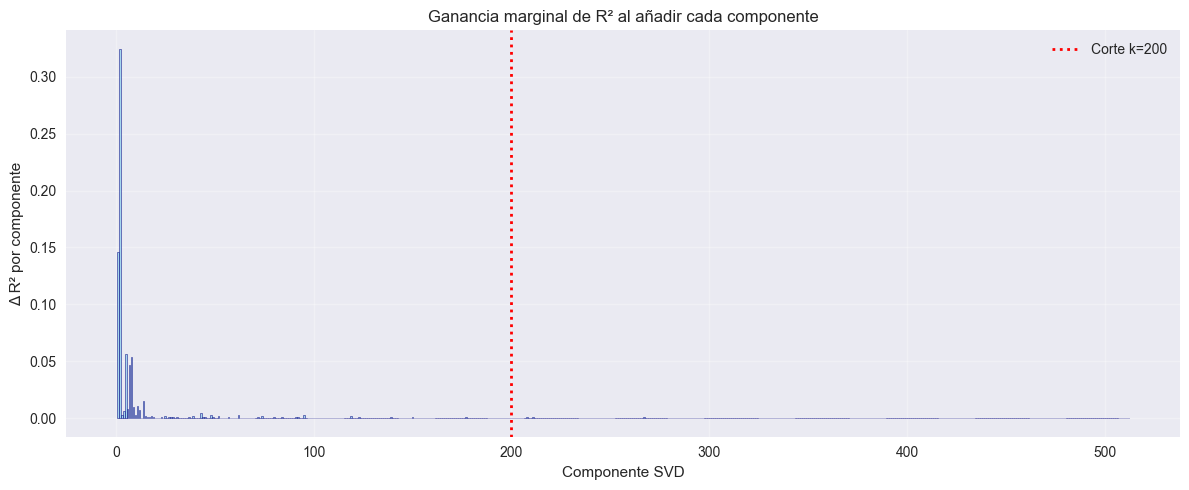


RESUMEN DEL ANÁLISIS SVD
Películas analizadas: 14963
Dimensiones originales: 3072
Componentes analizados: 512
Punto de corte sugerido: 200
R² máximo alcanzado: 0.766
R² en el corte: 0.749
Varianza explicada en el corte: 69.2%


In [9]:
# SVD Analysis - Versión Simplificada
# Analiza cómo crece la varianza explicada de REVENUE al añadir componentes SVD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge

# ---------- Configuración ----------

embedding_col = "embedding"
revenue_col = "revenue_real_2023"
max_components = 512
n_splits = 5
use_log_revenue = True
random_state = 42
elbow_eps = 1e-6
elbow_window = 10
save_path = "../../images/svd_revenue_explained.png"

# ---------- Helpers ----------
def unwrap_embedding(col):
    vals = col.to_numpy() if isinstance(col, (pd.Series, pd.DataFrame)) else np.asarray(col)
    out = []
    for v in vals:
        if isinstance(v, (list, tuple)):
            out.append(np.asarray(v, dtype=np.float32))
        elif isinstance(v, np.ndarray):
            out.append(v.astype(np.float32))
        else:
            raise ValueError("Embedding con formato desconocido.")
    return np.vstack(out)

def l2_normalize_rows(X, eps=1e-12):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.maximum(norms, eps)

# ---------- Cargar y procesar datos ----------
print("Cargando datos...")
df = pd.read_pickle(DATA_PATH)
df = df[df[embedding_col].notna() & (df[revenue_col] > 0)].copy()

print(f"Datos cargados: {len(df)} películas")

# Preparar X (embeddings) y y (revenue/log-revenue)
X = unwrap_embedding(df[embedding_col])
X = l2_normalize_rows(X)
y = np.log1p(df[revenue_col].values) if use_log_revenue else df[revenue_col].values

print(f"Shape de embeddings: {X.shape}")

# ---------- SVD sobre embeddings ----------
print("Aplicando SVD...")
n_comp = int(min(max_components, X.shape[1], X.shape[0]-1))
svd = TruncatedSVD(n_components=n_comp, random_state=random_state)
Z = svd.fit_transform(X)  # (n_samples, n_comp)
evr_cum = np.cumsum(svd.explained_variance_ratio_)  # Varianza explicada acumulada

print(f"SVD completado con {n_comp} componentes")

# ---------- Análisis R² vs componentes ----------
print("Analizando R² para diferentes números de componentes...")
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
model = Ridge(alpha=1.0, random_state=random_state)

r2_means = []
r2_stds = []

for k in range(1, n_comp + 1):
    if k % 50 == 0:
        print(f"Procesando k={k}...")

    scores = cross_val_score(model, Z[:, :k], y, cv=kf, scoring="r2")
    r2_means.append(scores.mean())
    r2_stds.append(scores.std())

r2_means = np.array(r2_means)
r2_stds = np.array(r2_stds)
deltas = np.diff(np.r_[0, r2_means])  # ganancia marginal por componente

# ---------- Encontrar punto de corte ----------
cut_k = None
for k in range(elbow_window, len(deltas)):
    if np.mean(deltas[k-elbow_window:k]) < elbow_eps:
        cut_k = k
        break

if cut_k is None:
    cut_k = int(np.argmax(r2_means) + 1)

print(f"\nSugerencia de corte: k={cut_k}")
print(f"R² en el corte: {r2_means[cut_k-1]:.3f}")
print(f"Varianza acumulada: {evr_cum[cut_k-1]*100:.1f}%")

# ---------- Generar gráficas ----------
ks = np.arange(1, n_comp + 1)

# Gráfica principal
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(ks, r2_means, label="R² CV (revenue)", linewidth=2, color='blue')
ax1.fill_between(ks, r2_means - r2_stds, r2_means + r2_stds, alpha=0.15, label="±1σ")
ax1.set_xlabel("Número de componentes SVD (k)")
ax1.set_ylabel("R² (CV) sobre revenue", color='blue')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(ks, evr_cum[:len(ks)], linestyle="--", label="Varianza acumulada de X",
         alpha=0.8, color='orange')
ax2.set_ylabel("Varianza acumulada de X", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.axvline(cut_k, color="red", linestyle=":", linewidth=2, label=f"Corte sugerido k={cut_k}")
ax1.legend(loc="lower right")
ax2.legend(loc="center right")

plt.title("Crecimiento de R² (revenue) vs. # componentes SVD\n+ Varianza acumulada del embedding (X)")
plt.tight_layout()

if save_path:
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Figura guardada en: {save_path}")

plt.show()

# Gráfica de ganancias marginales
plt.figure(figsize=(12, 5))
bars = plt.bar(ks, deltas, alpha=0.7, color='skyblue', edgecolor='navy', linewidth=0.5)
plt.axvline(cut_k, color="red", linestyle=":", linewidth=2, label=f"Corte k={cut_k}")
plt.xlabel("Componente SVD")
plt.ylabel("Δ R² por componente")
plt.title("Ganancia marginal de R² al añadir cada componente")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

if save_path:
    out2 = Path(save_path).with_name(Path(save_path).stem + "_marginal.png")
    plt.savefig(out2, dpi=150, bbox_inches='tight')
    print(f"Figura (Δ) guardada en: {out2}")

plt.show()

# ---------- Resumen final ----------
print("\n" + "="*50)
print("RESUMEN DEL ANÁLISIS SVD")
print("="*50)
print(f"Películas analizadas: {len(df)}")
print(f"Dimensiones originales: {X.shape[1]}")
print(f"Componentes analizados: {n_comp}")
print(f"Punto de corte sugerido: {cut_k}")
print(f"R² máximo alcanzado: {max(r2_means):.3f}")
print(f"R² en el corte: {r2_means[cut_k-1]:.3f}")
print(f"Varianza explicada en el corte: {evr_cum[cut_k-1]*100:.1f}%")
print("="*50)